# Shelter Animal Outcomes
### Talieh, John, Sean, Subhashini

In [2]:
%matplotlib inline

from datetime import date, datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.cross_validation import KFold

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import cross_validation

from patsy import dmatrices, dmatrix

pd.set_option('display.max_columns', None)

In [3]:
train_data = pd.read_csv('train.csv', parse_dates=['DateTime'])
test_data = pd.read_csv('test.csv', parse_dates=['DateTime'])

n_train_data = len(train_data.index)

## 1. Data Exploration

### Data Description

The provided data consists of the following fields:

* **AnimalID:** An ID for each animal. Used for identifying results when making submissions to Kaggle.

* **Name:** The name of each animal, if any.

* **DateTime:** The date and time _on which the outcome occurred._ The date or time on which the animal was received by the shelter is not included in the data set.

* **OutcomeType (train only):** The outcome we are trying to predict. There are four possible outcomes: adoption, transfer (e.g., to a rescue or another shelter), return to owner, euthanasia, or death for other reasons.

* **OutcomeSubtype (train only):** More details on the nature of the outcome. This column is not included in the test set, and we are not scored for predicting it, so we generally ignored it.

* **AnimalType:** Whether the animal is a dog or a cat.

* **SexuponOutcome:** This feature contains information about both the animal's sex, and whether it has been spayed or neutered at the time of the outcome. The value may be NA.

* **AgeuponOutcome:** The animal's age at the time of outcome, given as an integral number of days, weeks, months or years. The value may be NA.

* **Breed:** The animal's breed. In the case of mixed breeds, it will be denoted as either a combination of two breeds separated by a slash ("Dachshund/Beagle"), or a single breed followed by the word Mix ("Domestic Shorthair Mix"). The value may be NA.

* **Color:** The animal's color and color pattern. It may be a singe color ("Tan") or two colors separated by a slash ("Brown/White"), plus an optional word describing the color pattern ("Orange Tabby", "Black/White Point").

In [4]:
train_data.head(5)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [5]:
# Utility functions
# From: http://stackoverflow.com/a/28688724
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('4-winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('1-spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('2-summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('3-autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('4-winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

### Combining the training and submission data.

For the sake of simplicity in data exploration and feature engineering, we are combining the train and test data into a single data frame to operate on for feature engineering, and then separating it back out again before training and testing. Jupyter notebooks are more manageable if most the work is done in a global scope, and that way of working doesn't lend itself as well to keeping the sets separate because we would then need to worry about managing state in a way that lets us apply our feature engineering to both data sets separately while still staying coherent.

In real life this should not be done because it will adversely impact the generalizability of the data. However, the Kaggle competition is already different from real life in many ways. Generalizing well to future data is not one of the goals, so the test set is not a tool for estimating how accurate the model will be on future data the way it would be in a real-world situation. Instead, the test set is an end in and of itself, and any concerns about the validity of the test set score are tangential at best. Furthermore, the train and test sets include some variables that can only be known after the outcome has already been determined: The date and time of the outcome, the animal's age when the outcome occurs, and possibly also whether or not the animal has been spayed or neutered at the time of the outcome.

For Kaggle purposes it may also help our score in cases where the distributions of some variables differ between the train and test sets. In practice we did not find any significant differences, but it was a consideration.

In [6]:
feature_columns = ['AnimalID', 'Name', 'DateTime', 'AnimalType', 'SexuponOutcome', 
                    'AgeuponOutcome', 'Breed', 'Color', 'OutcomeType']

train_features = train_data.loc[:, feature_columns]
test_features = test_data.loc[:, feature_columns]

data = pd.concat((train_features, test_features), ignore_index=True)

In [7]:
data['Season'] = data.DateTime.map(get_season)

data['Sex X Species'] = data.SexuponOutcome + ' ' + data.AnimalType

data['Month'] = data.DateTime.apply(lambda d: d.strftime('%m-%B'))   # 'January', 'Feburary', . . .
data['WeekDay'] = data.DateTime.apply(lambda d: d.strftime('%w-%A')) # 'Sunday', 'Monday', . . .  

In [8]:
train_data = data[:n_train_data]
test_data = data[n_train_data:]

print 'Size of training set: %d' % len(train_data.index)
print 'Size of submission set: %d' % len(test_data.index)

Size of training set: 26729
Size of submission set: 11456


### Comparing train and test data distributions

In [9]:
train_data.describe()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeType,Season,Sex X Species,Month,WeekDay
count,26729,19038,26729,26729,26728,26711,26729,26729,26729,26729,26728,26729,26729
unique,26729,6374,22918,2,5,44,1380,366,5,4,10,12,7
top,A705677,Max,2015-08-11 00:00:00,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White,Adoption,3-autumn,Neutered Male Dog,10-October,6-Saturday
freq,1,136,19,15595,9779,3969,8810,2824,10769,7777,6714,2881,4348
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-02-21 19:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Utility functions for plotting

In [10]:
# Function to plot bar charts of categorical variables, with 
# train and test bars side-by-side. Hard-coded to use data from global env
def barplot_testvtrain(field_name):
    train_size = len(train_data.index) * 1.0
    test_size = len(test_data.index) * 1.0

    train_dist = train_data.groupby(field_name).size() / train_size
    test_dist = test_data.groupby(field_name).size() / test_size
    
    indices = np.arange(train_dist.size)
    width = .35
    
    fig, ax = plt.subplots()
    plt.title('{} distribution'.format(field_name))
    
    train_rects = ax.bar(indices, train_dist, width, color='r')
    test_rects = ax.bar(indices + width, test_dist, width, color='b')

    ax.set_xticks(indices + width)
    ax.set_xticklabels(train_dist.index, rotation=45)

    ax.legend((train_rects[0], test_rects[0]), ('Train', 'Test'), loc=0)
    plt.show()
    
# Function to generate stacked bar charts of outcome v. categorical variable,
# hard-coded to use data from global env
def barplot_stacked(field_name, rescale=True):
    # Making a copy of the data to use for plotting.
    # Copy is needed 'cuz I'm dropping NAs.
    plot_data = pd.DataFrame()
    plot_data[field_name] = train_data[field_name]
    plot_data['OutcomeType'] = train_data.OutcomeType
    plot_data = plot_data.dropna()

    # List of outcomes in order to stack, together with assigned color
    outcomes = [('Adoption', 'r'), 
                ('Transfer', 'b'), 
                ('Return_to_owner', 'g'), 
                ('Euthanasia', 'y'), 
                ('Died', 'm')]

    # Getting information about the categories in the variable
    categories = plot_data[field_name].unique()
    categories.sort()
    cat_counts = plot_data.groupby(field_name).size()
    indices = np.arange(categories.size)
    
    width = .75
    barsets = []
    
    # Series of 0s for all categories, added to distributions
    # to ensure that there's an entry for every category.
    zero = pd.Series({c:0 for c in categories})
    # Keeps track of bottoms. Bottoms are just top of previous one.
    bottoms = pd.Series({c:0 for c in categories})

    fig, ax = plt.subplots()
    if(rescale):
        plt.title('Outcome rates by {}'.format(field_name))
    else:
        plt.title('Outcomes by {}'.format(field_name))

    # Loop over outcomes, generate bars, and stack them
    for outcome, c in outcomes:
        dist = plot_data.loc[plot_data.OutcomeType == outcome] \
                         .groupby(field_name) \
                         .size()
        if(rescale):
            dist = dist / cat_counts
                    
        dist = zero.add(dist, 'index', fill_value=0.0)

        # Saving barset for later because it's needed to draw the legend
        bs = ax.bar(indices, dist, width, color=c, bottom = bottoms)
        barsets.append(bs)
        
        # The bottom of the next round of bars will be the top of this one.
        bottoms = bottoms.add(dist, 'index', fill_value=0.0)

    # Drawing category labels
    ax.set_xticks(indices + (width / 2))
    ax.set_xticklabels(categories, rotation=90)
    
    if(rescale):
        ax.set_ylim(0, 1)
    # Drawing legend outside of plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend([bs[0] for bs in barsets], 
              [n[0] for n in outcomes], 
              loc='center left', 
              bbox_to_anchor=(1, 0.5))
    
    plt.show()

### Comparing the training to the submission data to see if they are balanced.

Overall the distributions of the key variables we are using are roughly the same between the test and train sets. This gives us some confidence that we don't need to worry much about extrapolation.

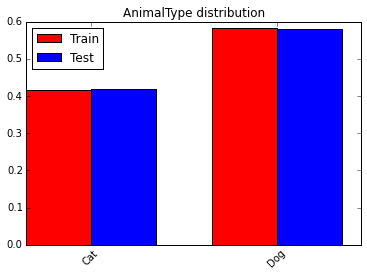

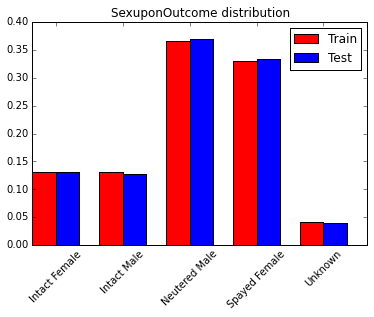

In [11]:
barplot_testvtrain('AnimalType')
barplot_testvtrain('SexuponOutcome')

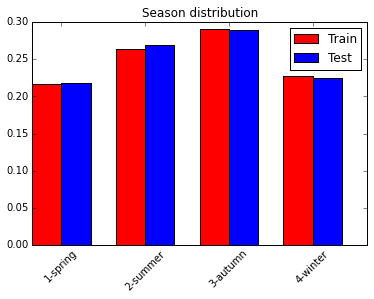

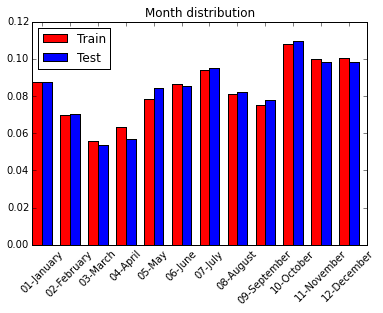

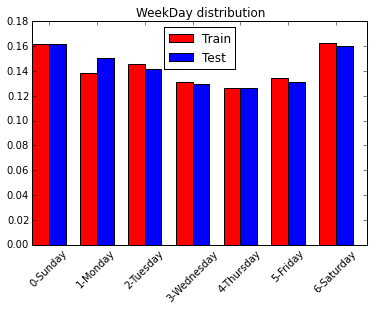

In [12]:
barplot_testvtrain('Season')
barplot_testvtrain('Month')
barplot_testvtrain('WeekDay')

### Are there any immediately apparent trends in the data?

Some initial analysis of the data indicates a number of predictive relationships. For example, while adoption and euthanasia rates are roughly the same for both species, cats are much more likely to be transferred and dogs are much more likely to be reunited with their owners.

We don't see huge differences based on sex, but, not surprisingly, whether or not an animal has been fixed is strongly correlated with outcomes. Intact animals are vastly less likely to be adopted, possibly because of the additional cost of needing to buy the surgery if one adopts an intact animal. Possibly as a result,t hey are also much more likely to be euthanized. On the other hand, their chances of being transferred are vastly greater. It's uncertain why this should be, but one could speculate that it's because the shelter is not equipped to perform spay or neuter operations, and is transferring them to a facility that is.

Digging a little deeper, we also find that for certain outcomes sex has a differential impact betwen the two species. For dogs, being intact has little impact on likelihood of being reunited with the owner. For intact cats, though, the odds of being reunited with an owner are effectively nil.

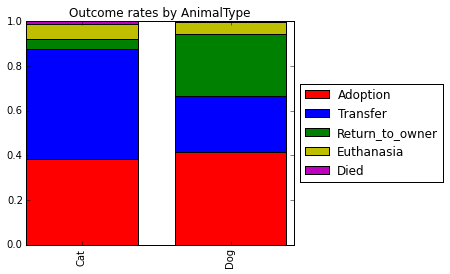

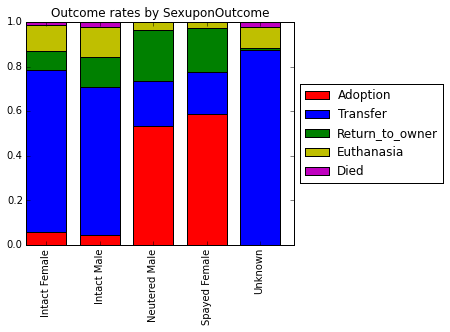

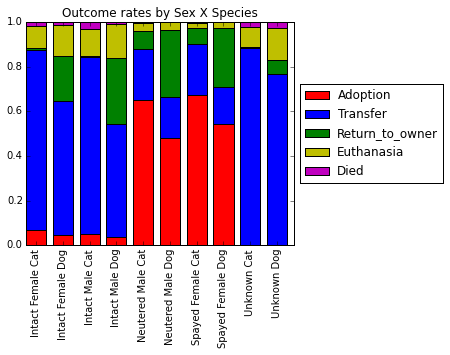

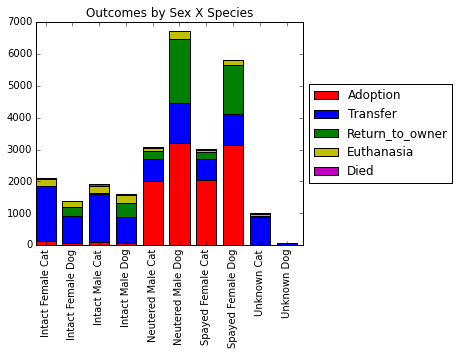

In [13]:
barplot_stacked('AnimalType')
barplot_stacked('SexuponOutcome')
barplot_stacked('Sex X Species')
barplot_stacked('Sex X Species', rescale=False)

We also find some evidence of seasonality in the data. The per-season data indicates that adoption rates steadily increase, and transfer rates steadily decline, as the year progresses. The pattern largely persists when we look look at things on a monthly basis, but the cyclical pattern becomes more apparent.. On that scale there appears to be a distinct lull in adoptions in the spring, and a lesser one in the autumn.

Unsurprisingly, looking at things by day of week reveals that people are more likely to adopt on the weekends. The relative likelihood of transfer diminishes. The absolute number of reunitings is roughly constant throughout the week, but the relative likelihood diminishes due to the large spike in weekend adoptions.

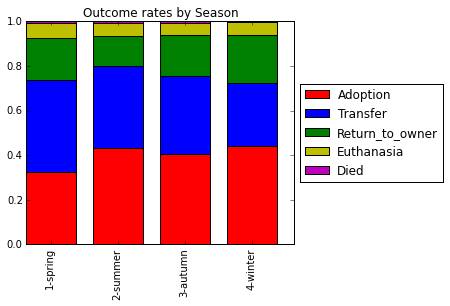

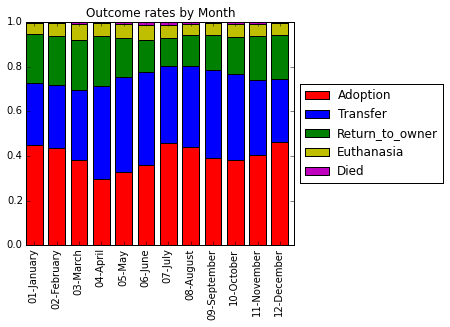

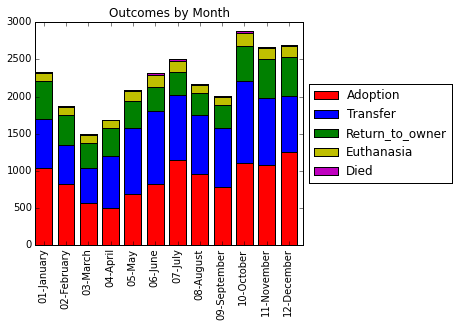

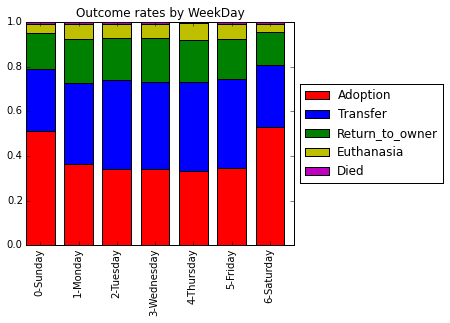

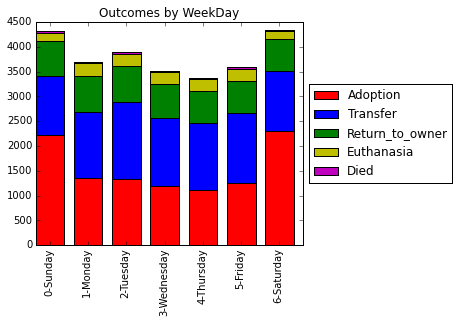

In [14]:
barplot_stacked('Season')
barplot_stacked('Month')
barplot_stacked('Month', rescale=False)
barplot_stacked('WeekDay')
barplot_stacked('WeekDay', rescale=False)

## 2. Feature Selection and Model Testing

### Multiple approaches to feature engineering were attempted

**Common Utility Functions**

In [15]:
# Converts age to a # of years, or returns NA if input is NA
def age_years(x):
    # We want to skip nan's
    try:
        age = int(x.split(' ')[0])

        if 'month' in x:
            age /= 12.0

        elif 'week' in x:
            age /= 52.0

        elif 'day' in x:
            age /= 365.0

        else:
            age = float(age)

        return age
    except AttributeError:
        return x

def draw_cm(y_true, y_pred,label_names):
    
    def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(label_names))
        plt.xticks(tick_marks, label_names, rotation=45)
        plt.yticks(tick_marks, label_names)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    cm = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm)
    
# use K-fold cross validation with k=6

def fit_model(clf):
    labels =  train_labels.cat.categories
    
    kf = KFold(train_data.shape[0], n_folds=6)

    ypp = []
    mll = []
    idx = 0
    for train_index, test_index in kf:
        X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
        y_train, y_test = train_labels.iloc[train_index], train_labels.iloc[test_index]
        #print X_train.shape, X_test.shape
        clf.fit(X_train, y_train)
        ypp.append(clf.predict_proba(X_test))
        mll.append(metrics.log_loss(y_test, ypp[idx]))
        idx += 1

    print "Log Loss (each iteration) :\n", '\n'.join([str(x) for x in mll])
    print "Std Deviation Log Loss :\n", np.std(mll)
    
    # Get the highest probability value
    y_pred = labels[np.argmax(np.vstack(ypp), axis=1)]
    
    print metrics.classification_report(train_labels, y_pred)
    draw_cm(train_labels, y_pred, labels)
    
def draw_rf_importances(clf, n_features = 50):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)

    indices = np.argsort(importances)[::-1]

    print 'Top features: '
    print train_data.columns.values[indices[:n_features]]

    # We have some many features let's 
    # just look at the first n_features
    plt.figure(figsize=(10,10))
    plt.title("Feature importances, first %d" % n_features)
    plt.bar(range(n_features),
            importances[indices][:n_features],
            color="g",
            yerr=std[indices][:n_features],
            align="center")

    plt.xticks(range(n_features), indices, rotation=70)

    plt.xlim([-1, n_features])
    plt.xlabel('Feature Indices')
    plt.grid()
    plt.show()

### This is common to all the approches to creating features

In [16]:
# read in fresh train and test data
train = pd.read_csv('train.csv', parse_dates=['DateTime'])
test = pd.read_csv('test.csv', parse_dates=['DateTime'])

# get number of training elements
train_num = train.shape[0]

train.rename(columns={'AnimalID': 'ID'}, inplace=True)
all_data = pd.concat((train, test), axis=0, ignore_index=True)


# This is to make use of the fit_model function above without too much modification.
train_labels = pd.DataFrame(train['OutcomeType'], dtype='category')['OutcomeType']

## Merged feature set

In [17]:
fs = pd.DataFrame()

# ID
fs['ID'] = all_data['ID']

# Name

fs['HasName'] = all_data.Name.notnull()

# Date

fs['Season'] = all_data.DateTime.map(get_season)
fs['Month'] = all_data.DateTime.apply(lambda d: d.strftime('%B')) # Full name of month
fs['WeekOfYear'] = all_data.DateTime.apply(lambda d: d.strftime('%U')) # Week of the year
fs['WeekDay'] = all_data.DateTime.apply(lambda d: d.strftime('%A')) # Full name of day
fs['Hour'] = all_data.DateTime.apply(lambda d: d.strftime('%H'))
fs['AmPm'] = all_data.DateTime.apply(lambda d: d.strftime('%p'))

# AnimalType

fs['AnimalType'] = all_data.AnimalType

# SexuponOutcome

fs['Sex'] = all_data.SexuponOutcome
fs.loc[fs.Sex.isnull(), 'Sex'] = 'Unknown'

# AgeuponOutcome

fs['AgeYears'] = all_data.AgeuponOutcome.map(age_years)
# fs['AgeYearsSquared'] = fs.AgeYears * fs.AgeYears
# fs['LogAgeYears'] = np.log(fs.AgeYears)

#create cat and dog age categories 
#source - http://www.akc.org/learn/family-dog/how-to-calculate-dog-years-to-human-years/
#http://icatcare.org/advice/how-guides/how-tell-your-cat%E2%80%99s-age-human-years
age_labels_dogs=['baby', 'adolescent', 'adult', 'senior']
age_ranges_dogs=[0.0, 1.0, 2.0, 7.0, 30.0]
age_ranges_cats=[0.0, 0.5, 2.0, 6.0, 10.0,15.0, 30.0]
age_labels_cats=['baby', 'adolescent', 'adult','mature', 'senior', 'geriatric']


#compute the dog age and cat age categories separately, then merge them
fs['dog_ages'] = pd.cut(fs['AgeYears'][fs['AnimalType']=='Dog'], age_ranges_dogs,  labels=age_labels_dogs)
fs['cat_ages'] = pd.cut(fs['AgeYears'][fs['AnimalType']=='Cat'], age_ranges_cats,  labels=age_labels_cats)
#merge
fs['AgeCategory'] = [fs['dog_ages'][x] 
                               if not pd.isnull(fs['dog_ages'][x]) 
                               else fs['cat_ages'][x] 
                                   for x in range(fs['dog_ages'].size)]

# Drop the temp columns
fs.drop(['dog_ages', 'cat_ages'], axis=1, inplace=True)

fs.loc[fs.AgeYears.isnull(), 'AgeYears'] = 0
fs.loc[fs.AgeCategory.isnull(), 'AgeCategory'] = 'Unknown'


# Breed

fs['IsMix'] = all_data.Breed.str.contains('Mix|/')
fs['CleanBreed'] = all_data.Breed.str.replace(' Mix', '')
fs['BreedBits'] = fs.CleanBreed.str.split('/')
fs['Breed1'] = fs.BreedBits.str[0]
fs['Breed2'] = fs.loc[fs.CleanBreed.str.contains('/')].BreedBits.str[1]
fs.loc[(fs.Breed2.isnull()), 'Breed2'] = 'None'

fs.drop(['CleanBreed', 'BreedBits'], axis=1, inplace=True)

# Color

# Pulling out separate features for merle/tick/tabby/brindle/point
fs['IsMerle'] = all_data.Color.str.contains('Merle')
fs['IsTick'] = all_data.Color.str.contains('Tick')
fs['IsTabby'] = all_data.Color.str.contains('Tabby')
fs['IsBrindle'] = all_data.Color.str.contains('Brindle')
fs['IsPoint'] = all_data.Color.str.contains('Point')
fs['IsTiger'] = all_data.Color.str.contains('Tiger')

# Then remove them
fs['CleanColor'] = all_data.Color.str.replace(' (Merle|Tick|Tabby|Brindle|Point|Tiger)', '')
fs['ColorBits'] = fs.CleanColor.str.split('/')

# And split to get rest
fs['Color1'] = fs.ColorBits.str[0]
fs['Color2'] = fs.loc[fs.CleanColor.str.contains('/')].ColorBits.str[1]
fs.loc[(fs.Color2.isnull()), 'Color2'] = 'None'

fs.drop(['CleanColor', 'ColorBits'], axis=1, inplace=True)

fs.head(2)

,ID,HasName,Season,Month,WeekOfYear,WeekDay,Hour,AmPm,AnimalType,Sex,AgeYears,AgeCategory,IsMix,Breed1,Breed2,IsMerle,IsTick,IsTabby,IsBrindle,IsPoint,IsTiger,Color1,Color2
0,A671945,True,4-winter,February,06,Wednesday,18,PM,Dog,Neutered Male,1,baby,True,Shetland Sheepdog,None,False,False,False,False,False,False,Brown,White
1,A656520,True,3-autumn,October,41,Sunday,12,PM,Cat,Spayed Female,1,adolescent,True,Domestic Shorthair,None,False,False,True,False,False,False,Cream,None


## Dummy coding features and generating some interactions

In [18]:
fs_coded = dmatrix('AnimalType + HasName + Sex + AgeYears + AgeCategory + IsMix ' + 
                   '+ Season + Month + WeekOfYear + WeekDay + Hour + AmPm ' +
                   '+ IsMerle + IsTick + IsTabby + IsBrindle ' +
                   '+ IsPoint + IsTiger ' +
                   '+ AnimalType:HasName + AnimalType:Sex + AnimalType:AgeYears ' +
                   '+ AnimalType:AgeCategory + AnimalType:IsMix + AnimalType:Month ' +
                   '+ AnimalType:WeekDay ' +
                   '+ Sex:IsMix ' +
                   '+ Breed1 + Breed2 + Color1 + Color2',  
               fs, return_type='dataframe', NA_action='raise')

print 'Feature count: {}'.format(len(fs_coded.dtypes))

Feature count: 595


In [19]:
train_data = fs_coded[:train_num]
n_train_data = len(train_data.index)

test_data = fs_coded[train_num:]
n_test_data = len(test_data.index)

print '# train rows is {} (should be {})'.format(n_train_data, train_num)
print '# test rows is {} (should be {})'.format(n_test_data, fs_coded.shape[0] - train_num)

# train rows is 26729 (should be 26729)
# test rows is 11456 (should be 11456)


Log Loss (each iteration) :
0.789072359616
0.799164298914
0.78273163166
0.806598033507
0.780445761308
0.792386939798
Std Deviation Log Loss :
0.00905654881237
             precision    recall  f1-score   support

   Adoption       0.69      0.84      0.76     10769
       Died       0.75      0.03      0.06       197
 Euthanasia       0.69      0.11      0.19      1555
Return_to_owner       0.49      0.48      0.49      4786
   Transfer       0.76      0.71      0.73      9422

avg / total       0.68      0.68      0.66     26729

Confusion matrix, without normalization
[[9028    0    5 1125  611]
 [  17    6    4   13  157]
 [ 235    0  175  346  799]
 [1960    0   14 2289  523]
 [1855    2   54  866 6645]]


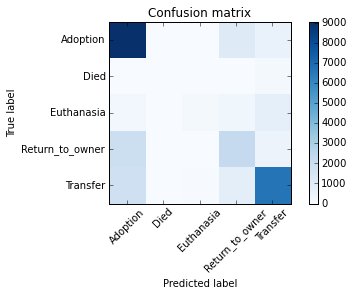

In [20]:
clf = RandomForestClassifier(n_estimators=1000, n_jobs=4, max_depth=31)
fit_model(clf)

### Retrain with entire dataset, classify submission data, and prepare submission

In [23]:
y_pred_sub = clf.fit(train_data, train_labels).predict_proba(test_data)

In [29]:
sub = pd.DataFrame(y_pred_sub, columns=['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'])
sub.insert(0, 'ID', test.ID.astype(int))

In [30]:
sub.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.096677,0.001208,0.040442,0.156568,0.705106
1,2,0.676413,0.001588,0.014396,0.186891,0.120712
2,3,0.260164,0.000112,0.039224,0.283684,0.416815
3,4,0.084021,0.022937,0.057310,0.141479,0.694252
4,5,0.488488,0.000872,0.024240,0.344179,0.142221


In [31]:
sub.to_csv("submission_final.csv", index=False)

### Some additional features and models experimented with

### Feature Set V1

In [ ]:
# create a new data frame to store our new features.
fsv1 = pd.DataFrame()

#We need an index to work with
fsv1['ID'] = all_data['ID']

# is it a cat?
fsv1['is_cat'] = all_data['AnimalType'].map(lambda x: 1 if 'Cat' in x else 0) 

# color stuff
fsv1 = fsv1.join(all_data['Color'].apply(
        lambda x: pd.Series({'color_1':x.split('/')[0], 'color_2':x.split('/')[1]}
                            if len(x.split('/')) == 2 else {'color_1':x, 'color_2':'NaN'})))

# Convert the date into seasons

fsv1['Season'] = data.DateTime.map(get_season)
fsv1 = fsv1.join(pd.get_dummies(all_data['DateTime'].map(get_season)))

# Add in the breed information
fsv1 = fsv1.join(all_data['Breed'].apply(lambda x: get_breed_1(x)))

fsv1['age_years'] = all_data['AgeuponOutcome'].map(age_years)

# what is the gender, I am coding all unknowns as -999
fsv1['is_female'] = all_data['SexuponOutcome'].map(gender)

fsv1['is_fixed'] = all_data['SexuponOutcome'].map(fixed)

***In this case it's ok to dummy code the breed across the entire data set because there are only three possible values ***

In [ ]:
fsv1 = fsv1.join(pd.get_dummies(fsv1['Breed']))

***But because there are a wide assortment of colors, it seems to make more sense to split the data up and avoid information leakage.***

In [ ]:
# Lets break things back up before continuing 
X_train_all = fsv1.iloc[:train_num]
y_train_all = all_data['OutcomeType'][:train_num]

# Submission data
X_test_all = fsv1.iloc[train_num:]
ids_test = all_data['ID'][train_num:].values

X_train_all.shape, y_train_all.shape, X_test_all.shape, ids_test.shape

X_train, X_test, y_train, y_test = train_test_split(
    X_train_all, y_train_all, test_size=0.30, random_state=23)

In [ ]:
# vectorize the colors using our training data
cv = CountVectorizer(analyzer='word')
cv.fit(X_train['color_1'])

In [ ]:
X_train = X_train.join(pd.DataFrame(
        cv.transform(X_train['color_1']).todense(),
        index=X_train.index.values,
        columns=[x+'_1' for x in cv.get_feature_names()]))

In [ ]:
X_test = X_test.join(pd.DataFrame(
        cv.transform(X_test['color_1']).todense(),
        index=X_test.index.values,
        columns=[x+'_1' for x in cv.get_feature_names()]))

In [ ]:
# We want to drop the original non-binary columns now.
cols_to_drop = ['color_1',
                'color_2',
                'Breed',
                'Season',
                'ID']

X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)

X_train = X_train.fillna(value=-999)
X_test = X_test.fillna(value=-999)

In [ ]:
# Quick Test
lr = LogisticRegression(random_state=23, max_iter=100)
y_pred = lr.fit(X_train, y_train).predict(X_test)
print np.mean(y_pred == y_test)

In [ ]:
train_data = X_train
# This is to make use of the fit_model function above without too much modification.
train_labels = pd.DataFrame(y_train, dtype='category')['OutcomeType']
ypp = fit_model(lr)

### Feature Set V2

In [ ]:
all_data = pd.concat((train, test), axis=0, ignore_index=True)

In [ ]:
all_data['OutcomeType']= all_data['OutcomeType'].str.lower()
all_data['OutcomeType']= all_data['OutcomeType'].str.strip()
all_data['OutcomeType']= all_data['OutcomeType'].astype('category')
#11456 null values in the outcome type; all correspond to test data
print "Null values in OutcomeType:", sum(pd.isnull(all_data['OutcomeType'])) 

**Name, AnimalType,SexUponoutcome*** are recoded to categories and dummy variables created where necessary

In [ ]:
#does it have a name?
all_data['Name'] = all_data['Name'].str.strip()
all_data['Hasname'] = all_data['Name'].map(lambda x: 1 if not pd.isnull(x) and x else 0)
print all_data['Hasname'].value_counts()

In [ ]:
all_data['AnimalType'] = all_data['AnimalType'].str.lower()
all_data['AnimalType'] = all_data['AnimalType'].str.strip()
all_data['Iscat'] = all_data['AnimalType'].map(lambda x: 1 if x=='cat' else 0)
#no missing values
print "Null Values in AnimalType:", sum(pd.isnull(all_data['Iscat']))  

**For age**, create 2 variables: 
- one a continuous float value for age in years 
- the other a categorical value for various life stages.

In [ ]:
all_data['SexuponOutcome'] = all_data['SexuponOutcome'].str.lower()
all_data['SexuponOutcome'] = all_data['SexuponOutcome'].str.strip()
all_data['SexuponOutcome'] = all_data['SexuponOutcome'].astype('category')
print all_data['SexuponOutcome'].value_counts()
#missing value, convert to Unknown category
all_data['SexuponOutcome'][pd.isnull(all_data['SexuponOutcome'])] = "unknown"
print "Null values in SexuponOutcome:", sum(pd.isnull(all_data['SexuponOutcome']))

all_data = pd.concat((all_data,pd.get_dummies(all_data['SexuponOutcome'])), axis=1)

In [ ]:
all_data['AgeuponOutcome'] = all_data['AgeuponOutcome'].str.lower()
all_data['AgeuponOutcome'] = all_data['AgeuponOutcome'].str.strip()
all_data['Ageyears'] = map(age_years_2, all_data['AgeuponOutcome'])
all_data['Ageyears'].describe()

#24 values are unknkown
print "Null values in AgeuponOutcome:", sum(pd.isnull(all_data['AgeuponOutcome'])) 
#all nulls were coded to 0
print "Null values in Ageyears:", sum(pd.isnull(all_data['Ageyears'])) 

In [ ]:

#create cat and dog age categories 
#source - http://www.akc.org/learn/family-dog/how-to-calculate-dog-years-to-human-years/
#http://icatcare.org/advice/how-guides/how-tell-your-cat%E2%80%99s-age-human-years
age_labels_dogs=['baby', 'adolescent', 'adult', 'senior']
age_ranges_dogs=[0.0, 1.0, 2.0, 7.0, 30.0]
age_ranges_cats=[0.0, 0.5, 2.0, 6.0, 10.0,15.0, 30.0]
age_labels_cats=['baby', 'adolescent', 'adult','mature', 'senior', 'geriatric']


#compute the dog age and cat age categories separately, then merge them
all_data['dog_ages'] = pd.cut(all_data['Ageyears'][all_data['AnimalType']=='dog'], age_ranges_dogs,  labels=age_labels_dogs)
all_data['cat_ages'] = pd.cut(all_data['Ageyears'][all_data['AnimalType']=='cat'], age_ranges_cats,  labels=age_labels_cats)
#merge
all_data['Agecategory'] = [all_data['dog_ages'][x] 
                               if not pd.isnull(all_data['dog_ages'][x]) 
                               else all_data['cat_ages'][x] 
                                   for x in range(all_data['dog_ages'].size)]

all_data['Agecategory'] = all_data['Agecategory'].astype('category')
print all_data['Agecategory'].value_counts()

#drop the temp columns
all_data.drop(['dog_ages', 'cat_ages'], axis=1, inplace=True)

#the AgeuponOutcome had 24 missing values, whereas the Agecategory has 59. The extra nulls are due to age=0
print "Null values in Agecategory:", sum(pd.isnull(all_data['Agecategory']))
#all_data['AgeuponOutcome'][pd.isnull(all_data['Agecategory'])]

all_data = pd.concat((all_data, pd.get_dummies(all_data['Agecategory'])), axis=1)


**Datetime field** is split up into several numerical variables, and one categorical variable AM/PM.
- Hour of day [00,23]
- Day of the week (0=Sunday,1=Monday, ..)
- Day of the month [00,32]
- Month [00-12]
- Week of the year [00,53]
- Two digit year

In [ ]:
all_data['Hour'] = all_data.DateTime.apply(lambda d: d.strftime('%H')).astype('int') # [00,23]
all_data['Ampm'] = all_data.DateTime.apply(lambda d: d.strftime('%p')) # Am/pm
all_data['Dayofweek'] = all_data.DateTime.apply(lambda d: d.strftime('%w')).astype('int') # [0(sunday),6]
all_data['Dayofmonth'] = all_data.DateTime.apply(lambda d: d.strftime('%d')).astype('int') # 01,02,..31
all_data['Month'] = all_data.DateTime.apply(lambda d: d.strftime('%m')).astype('int')   # Month as a number
all_data['Weekofyear'] = all_data.DateTime.apply(lambda d: d.strftime('%U')).astype('int')  # [00,53]
all_data['Year'] = all_data.DateTime.apply(lambda d: d.strftime('%y')).astype('int') # two digit year

all_data.Hour.value_counts()
all_data.Ampm.value_counts()
all_data.Dayofweek.value_counts()
all_data.Dayofmonth.value_counts()
all_data.Month.value_counts()
all_data.Weekofyear.value_counts()
all_data.Year.value_counts()

dummies = pd.get_dummies(all_data['Ampm'])
all_data = pd.concat((all_data, dummies), axis=1)

**Breed and Color** are coded in 2 separate ways:
1. Create a categorical meta variable for breed (purebreed, mixed, etc) and color (single, double, etc)
2. Use CountVectorizer to encode Breed and Color. 

Whereas Breed has around 138 unique categories and color has 366, once they are vectorized we get around 200 breed-related featues and 32 color-related features.

In [ ]:
all_data['Breed'] = all_data['Breed'].str.lower()
all_data['Breed'] = all_data['Breed'].str.strip()

#breed type
all_data['Breedtype'] = all_data['Breed'].map(get_breed_1)
all_data['Breedtype'].value_counts()

all_data = pd.concat((all_data, pd.get_dummies(all_data['Breedtype'])), axis=1)

all_data['Color'] = all_data['Color'].str.lower()
all_data['Color'] = all_data['Color'].str.strip()

all_data['Colortype'] = all_data['Color'].map(get_color)
all_data['Colortype'].value_counts()

#no missing values
print "Null values in Color:", sum(pd.isnull(all_data['Color']))
print "Null values in ColorType:", sum(pd.isnull(all_data['Colortype']))

all_data = pd.concat((all_data, pd.get_dummies(all_data['Colortype'], prefix='col')), axis=1)


In [ ]:
vec = CountVectorizer(min_df=10)
breeds = vec.fit_transform(all_data['Breed'])
breeds = breeds.toarray()
breeds.shape
#create new features from breed names
for ii in range(breeds.shape[1]):
    colname = 'breed_%d' %ii
    all_data[colname] = pd.Series(breeds[:,ii])

#--------------------------------------------------------------------------------------------------


vec = CountVectorizer(min_df=10)
colors = vec.fit_transform(all_data['Color'])
colors = colors.toarray()
colors.shape
#create new features from breed names
for ii in range(colors.shape[1]):
    colname = 'color_%d' %ii
    all_data[colname] = pd.Series(colors[:,ii])

######  That's it for feature engineering. Now split the train and test data back.

In [ ]:
train_data = all_data.iloc[:train_num]
test_data = all_data.iloc[train_num:]
test_ids = all_data['ID'][train_num:].values
train_labels = train_data.OutcomeType

print "train data:", train_data.shape, "Test data:", test_data.shape


In [ ]:
#drop the columns we don't need
cols_recoded = [
 'AgeuponOutcome',
 'AnimalType',
 'Breed',
 'Color',
 'DateTime',
 'Name',
 'SexuponOutcome',
 'Agecategory',
 'Breedtype',
 'Colortype',
 'unknown',
 'Ampm']


train_data = train_data.drop(cols_recoded, axis=1)
test_data = test_data.drop(cols_recoded, axis=1)

other_cols = [
    'ID',
    'OutcomeSubtype',
    'OutcomeType']

train_data = train_data.drop(other_cols, axis=1)
test_data = test_data.drop(other_cols, axis=1)

In [ ]:
#plain and simple
clf = LogisticRegression()
fit_model(clf)

In [ ]:
#with L1 regularization
clf = LogisticRegression(penalty="l1")
fit_model(clf)

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
fit_model(clf)

In [ ]:
draw_rf_importances(clf)